**Tarea 4: Gabriel Alvarez Castrillo C00368**

**PARTE I: MEMORIA COMPARTIDA**

El codigo es el siguiente:

```c++
#include <iostream>
#include <complex>
#include <omp.h>

// Función para determinar si un número c está fuera o dentro del conjunto
// de Maldenbrot con la cantidad de iteraciones máximas
int mandelbrot(const std::complex<double> &c, const int &maxits){
  std::complex<double> z = 0;
  int n = 0;
  while(abs(z) <= 2 && n < maxits){
    z = z * z + c;
    ++n;
  }
    
  return n;
}

int main(){

  // Ancho y alto de la salida del programa
  int width = 150;
  int height = 45;
  // Número máximo de iteraciones (corte)
  int max_iter = 1000;
  // Coordenadas en el plano complejo máximas y mínimas
  double minX = -2.0, maxX = 1.0;
  double minY = -1.0, maxY = 1.0;

  // Rutina principal para generar e imprimir el conjunto
  #pragma omp parallel for ordered
  for(int y = 0; y < height; ++y){
    #pragma omp ordered // Asegura que se impriman las líneas en orden
    {
      for(int x = 0; x < width; ++x){
        // Mapeo de pixeles a número complejo
        std::complex<double> c( minX + (maxX - minX) * x / width,
                                minY + (maxY - minY) * y / height );

        // Cálculo del número de iteraciones
        int n = mandelbrot(c, max_iter);

        // Se imprime un caracter dependiendo del número de iteraciones
        if(n == max_iter){
          std::cout << '#'; // Dentro del conjunto de Mandelbrot
        } 
        else{
          std::cout << '.'; // Fuera del conjunto de Mandelbrot
        }
      }
      std::cout << std::endl; // Siguiente línea en y
    }
  }

  return 0;
}
```

Donde los cambios para paralelización se hicieron en la siguiente sección:
```c++
// Rutina principal para generar e imprimir el conjunto
  #pragma omp parallel for ordered
  for(int y = 0; y < height; ++y){
    #pragma omp ordered // Asegura que se impriman las líneas en orden
    for(int x = 0; x < width; ++x){
```

Y se puede paralelizar esta parte porque, la evaluación de cada punto es independiente de los demás, por lo que el cálculo de Mandelbrot en cada píxel puede realizarse en paralelo. Y el bucle externo con "y" es el ideal ya que cada hilo puede procesar una fila completa sin interferencia entre hilos.

Además al utilizar ```#pragma omp ordered``` Nos aseguramos que se imprima en orden en la terminal y se vea de la misma forma tanto en serie como en paralelo, de la siguiente forma:

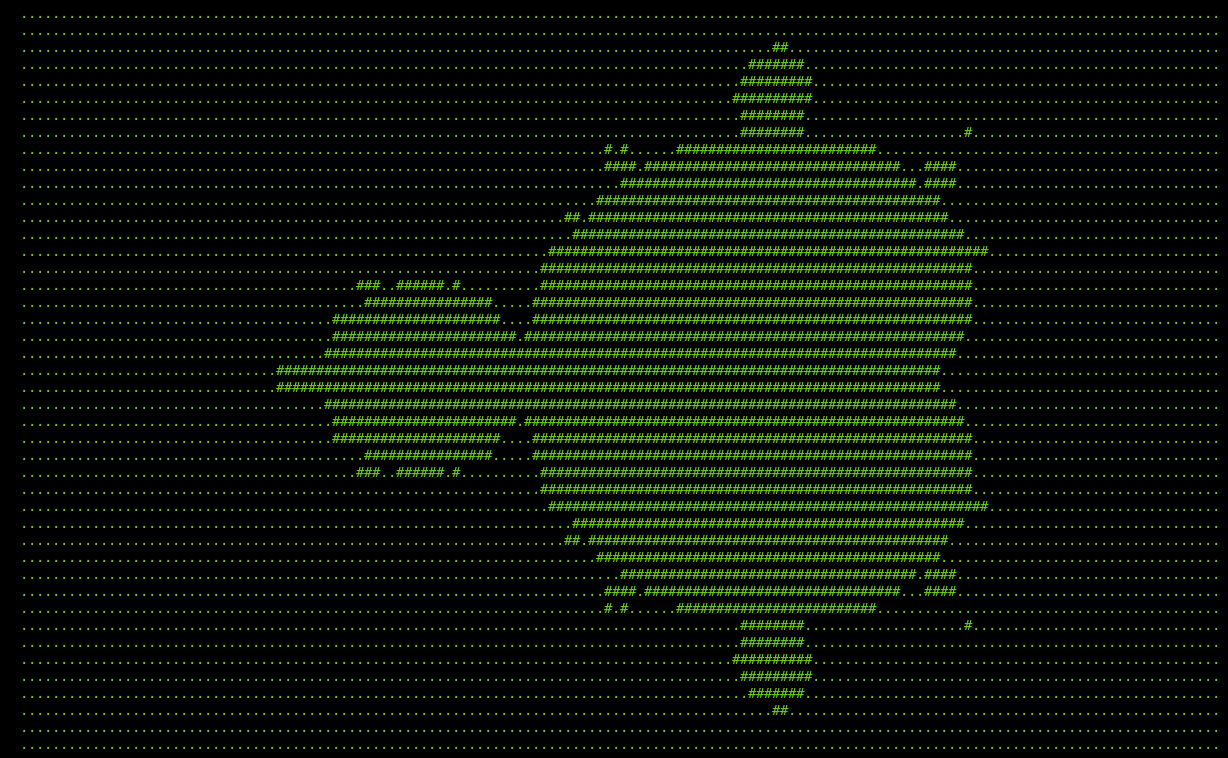

**PARTE II: MEMORIA DISTRIBUIDA**

El codigo es el siguiente:
```c++
#include <iostream>
#include <mpi.h>
#include <vector>
#include <cstdlib>

int main(int argc, char** argv) {
    
    MPI_Init(&argc, &argv); // Inicializa MPI

    // Inicializa MPI y obtiene el rango y número de procesos
    int rank, size;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank); // Obtiene el identificador del proceso
    MPI_Comm_size(MPI_COMM_WORLD, &size); // Obtiene el número total de procesos
    
    // Verifica si se proporcionó un argumento (tamaño del vector)
    if (argc != 2) {
        if (rank == 0) {
            std::cerr << "Uso: " << argv[0] << " [tamaño del vector]" << std::endl;
        }
        MPI_Finalize(); // Finaliza MPI
        return 1;
    }
    
    int N; 
    try {
        N = std::stoi(argv[1]); // Tamaño de los vectores A y B
    } catch (const std::invalid_argument& e) {
        if (rank == 0) {
            std::cerr << "Error: El tamaño del vector debe ser múltiplo del número de procesos." << std::endl;
        }
        MPI_Finalize();
        return 1;
    }

    // Calcula cuántos elementos tendrá cada proceso
    int nlocal = N / size;
    
    // Vectores locales y globales
    std::vector<int> local_a(nlocal), local_b(nlocal);
    std::vector<int> a, b;

    if (rank == 0) { // El proceso 0 inicializa los vectores globales
        a.resize(N);
        b.resize(N);
        for (int i = 0; i < N; i++) {
            a[i] = i + 1;  // a = [1, 2, 3, ..., N]
            b[i] = i + 1;  // b = [1, 2, 3, ..., N]
        }
    }
    
    // Distribuye los datos de los vectores a todos los procesos
    MPI_Scatter(a.data(), nlocal, MPI_INT, local_a.data(), nlocal, MPI_INT, 0, MPI_COMM_WORLD);
    MPI_Scatter(b.data(), nlocal, MPI_INT, local_b.data(), nlocal, MPI_INT, 0, MPI_COMM_WORLD);
    
    // Cada proceso calcula su producto punto local
    int productoLocal = 0;
    for (int i = 0; i < nlocal; i++) {
        productoLocal += local_a[i] * local_b[i];
    }
    
    // Realiza una reducción para obtener el producto punto total en el proceso 0
    int productoTotal = 0;
    MPI_Reduce(&productoLocal, &productoTotal, 1, MPI_INT, MPI_SUM, 0, MPI_COMM_WORLD);
    
    if (rank == 0) { // Solo el proceso 0 muestra el resultado
        std::cout << "Producto punto total: " << productoTotal << std::endl;
    }
    
    MPI_Finalize(); // Finaliza MPI
    return 0;
}

```